In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt

# dropping unnecessary columns

In [2]:
house_df = pd.read_csv('house_price_data.csv')
house_df.shape
y = house_df['SalePrice']
house_df.drop(columns='SalePrice',inplace = True)

len(house_df['MSZoning'].value_counts())
house_df.shape

(1460, 80)

In [3]:
# dropping columns whose NA percentage is greater than 50

na_df = pd.DataFrame({'col_name':house_df.columns, 'na_count': house_df. isnull().sum(),'na_pc' : house_df. isnull().sum()/house_df.shape[0]*100})
col_grt50_nas = list(na_df[na_df['na_pc']>50]['col_name'].values)
cols_to_drop = []
for col in house_df.columns:
    if len(house_df[col].value_counts()) == 1 or len(house_df[col].value_counts()) == house_df.shape[0] :
        cols_to_drop.append(col)
cols_to_drop = cols_to_drop + col_grt50_nas
cols_to_drop


['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']

In [4]:
house_df.drop(columns=cols_to_drop,inplace = True)


In [5]:
house_df.shape

(1460, 75)

# train_test_split

In [6]:
X_train,X_test,y_train,y_test = train_test_split(house_df,y,test_size=0.2,random_state=32)
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
457,20,RL,NaN,53227,Pave,IR1,Low,AllPub,CulDSac,Mod,...,137,0,0,0,0,0,3,2008,WD,Normal
403,60,RL,93.0,12090,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,123,0,0,0,0,0,7,2006,WD,Abnorml
1092,50,RL,60.0,8400,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,0,128,0,0,0,0,6,2008,WD,Normal
917,20,RL,NaN,17140,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,4,2009,WD,Normal
699,120,FV,59.0,4282,Pave,IR2,Lvl,AllPub,Inside,Gtl,...,158,0,0,0,0,0,7,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,50,RL,60.0,10930,Pave,Reg,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,0,4,2008,WD,Normal
88,50,C (all),105.0,8470,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,156,0,0,0,0,10,2009,ConLD,Abnorml
892,20,RL,70.0,8414,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,2,2006,WD,Normal
1334,160,RM,24.0,2368,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,5,2009,WD,Normal


# filling missing values after split

In [9]:
for col in X_train.columns:
    if X_train[col].dtype == 'int64' or X_train[col].dtype == 'float64':
        X_train[col].fillna(X_train[col].mean(),inplace= True)   # fill missing values of continous variables with mean
        X_test[col].fillna(X_train[col].mean(),inplace= True)
    if X_train[col].dtype == 'object':
        X_train[col].fillna(X_train[col].mode(),inplace= True)  # fill missing values of categorical variables with mode
        X_test[col].fillna(X_train[col].mode(),inplace= True)
    

# scaling the continous variables

In [10]:
con_cols = [col for col in X_train.columns if X_train[col].dtype == 'int64' or X_train[col].dtype == 'float64']

std_scaler = StandardScaler()

for col in con_cols:
    X_train[col] = std_scaler.fit_transform(np.array(X_train[col]).reshape(-1,1))
    X_test[col] = std_scaler.transform(np.array(X_test[col]).reshape(-1,1))
    
X_train[con_cols] 


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
457,-0.884330,-2.129195e-17,4.702739,-1.526697,0.381346,-0.543462,0.455005,-0.566013,1.466206,-0.290178,...,0.265998,0.999511,1.393156,-0.367255,-0.110203,-0.259782,-0.071069,-0.092052,-1.231765,0.135639
403,0.064044,1.045559e+00,0.170960,1.384621,-0.522127,0.902843,0.649710,2.966314,-0.971274,-0.290178,...,-0.241225,0.373749,1.178179,-0.367255,-0.110203,-0.259782,-0.071069,-0.092052,0.252963,-1.373180
1092,-0.173050,-4.631141e-01,-0.235541,-0.071038,-0.522127,-1.496708,-1.686745,-0.566013,-0.047391,-0.290178,...,0.484709,1.922510,-0.710547,1.666604,-0.110203,-0.259782,-0.071069,-0.092052,-0.118219,0.135639
917,-0.884330,-2.129195e-17,0.727284,-1.526697,0.381346,-0.477721,-1.394688,-0.566013,1.341711,-0.290178,...,-0.874091,-0.752622,-0.710547,-0.367255,-0.110203,-0.259782,-0.071069,-0.092052,-0.860583,0.890048
699,1.486603,-5.088315e-01,-0.689193,0.656791,-0.522127,1.100067,0.941767,-0.566013,-0.936328,-0.290178,...,0.270652,0.467614,1.715622,-0.367255,-0.110203,-0.259782,-0.071069,-0.092052,0.252963,0.135639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,-0.173050,-4.631141e-01,0.043171,-0.798868,0.381346,-0.839297,-1.686745,-0.566013,0.295517,-0.290178,...,-0.855478,-0.752622,-0.710547,-0.367255,-0.110203,-0.259782,-0.071069,-0.092052,-0.860583,0.135639
88,-0.173050,1.594168e+00,-0.227830,-2.254526,-3.232546,-1.825414,-0.129108,-0.566013,-0.971274,-0.290178,...,-2.195665,-0.752622,-0.710547,2.111510,-0.110203,-0.259782,-0.071069,-0.092052,1.366509,0.890048
892,-0.884330,-5.940407e-03,-0.233999,-0.071038,2.188292,-0.247627,0.893090,-0.566013,0.476799,-0.290178,...,-0.967160,0.749207,-0.710547,-0.367255,-0.110203,-0.259782,-0.071069,-0.092052,-1.602947,-1.373180
1334,2.434977,-2.108940e+00,-0.900045,-0.798868,0.381346,-0.017533,-0.713222,1.129504,0.699579,-0.290178,...,-0.148157,-0.752622,-0.157749,-0.367255,-0.110203,-0.259782,-0.071069,-0.092052,-0.489401,0.890048


# one hot encoding categorical columns

In [11]:

one_hot_train = pd.get_dummies(X_train[[col for col in X_train.columns if X_train[col].dtype == 'object']])
one_hot_test = pd.get_dummies(X_test[[col for col in X_test.columns if X_test[col].dtype == 'object']])
oe_train_final,oe_test_final=one_hot_train.align(one_hot_test,join='inner',axis=1) # includes only common columns excludes those which are in train but not in test
oe_train_final.shape

(1168, 196)

In [13]:
# concatinates scaled and one hot encoded data

X_train_final = pd.concat([X_train[con_cols],oe_train_final],axis=1)
X_train_final
X_test_final = pd.concat([X_test[con_cols],oe_test_final],axis=1)
X_test_final

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PavedDrive_Y,SaleType_COD,SaleType_ConLw,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
363,2.434977,-2.246092e+00,-0.975837,-0.071038,2.188292,0.048208,1.087795,2.205505e+00,-0.617446,-0.290178,...,1,0,0,0,1,0,0,0,1,0
529,-0.884330,7.125221e-15,2.437896,-0.071038,-2.329073,-0.444850,-0.469841,8.516779e-17,1.691170,-0.290178,...,1,0,0,0,1,0,1,0,0,0
1394,1.486603,-7.831358e-01,-0.715302,0.656791,-0.522127,1.165808,1.039119,-3.214677e-01,1.365736,-0.290178,...,1,0,0,1,0,0,0,0,0,1
803,0.064044,1.685602e+00,0.369364,2.112450,-0.522127,1.231549,1.185147,1.738151e+00,-0.971274,-0.290178,...,1,0,0,1,0,0,0,0,0,1
832,0.064044,-1.194592e+00,-0.109074,0.656791,0.381346,1.067196,0.893090,6.458465e-01,0.083657,-0.290178,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,0.064044,-5.940407e-03,-0.228711,-0.071038,-0.522127,0.771361,0.455005,4.593263e-03,0.806601,-0.290178,...,1,0,0,0,1,0,0,0,1,0
599,2.434977,-2.108940e+00,-0.946093,-0.071038,0.381346,0.311173,-0.226461,-5.660134e-01,-0.794360,3.398803,...,1,1,0,0,0,0,0,0,1,0
1141,0.064044,7.125221e-15,-0.025791,-0.798868,1.284819,0.179691,-0.421165,-3.269020e-01,-0.139124,-0.290178,...,1,0,0,0,1,0,0,0,1,0
498,-0.884330,-2.345273e-01,-0.301639,-0.798868,1.284819,-0.116145,0.941767,-8.235632e-02,0.011581,-0.290178,...,1,0,0,0,1,0,0,0,1,0


# calculating VIF

In [14]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_final.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train_final.values, i)
                   for i in range(len(X_train_final.columns))]
vif_data

,feature,VIF
0,MSSubClass,39.269049
1,LotFrontage,2.470068
2,LotArea,3.299906
3,OverallQual,5.398690
4,OverallCond,2.689175
...,...,...
227,SaleCondition_Abnorml,33.020415
228,SaleCondition_Alloca,5.316130
229,SaleCondition_Family,8.201747
230,SaleCondition_Normal,72.966692


# PCA

Text(0, 0.5, 'Explained Variance')

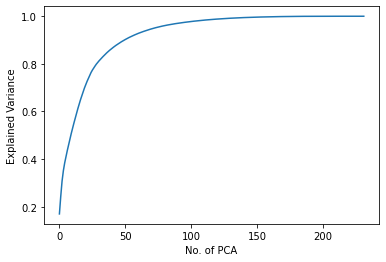

In [15]:
from sklearn.decomposition import  PCA

pca=PCA()
X_train_pca_df=pd.DataFrame(pca.fit_transform(X_train_final))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('No. of PCA')
plt.ylabel('Explained Variance')

In [12]:
X_train_pca_df

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,226,227,228,229,230,231
0,0.834112,-1.831890,3.997942,-0.843301,-0.753360,0.839635,0.501801,0.583824,-0.721835,-0.554812,...,7.003567e-16,8.708385e-17,3.536963e-16,-6.393393e-16,-2.842897e-16,-1.069242e-15,3.032611e-16,4.478848e-16,-2.747814e-16,-5.763841e-16
1,4.169029,3.113336,-1.252219,0.678042,-0.491114,-1.482203,-0.409057,-0.357237,0.413325,-0.192114,...,-1.047801e-15,-1.557368e-15,-1.890082e-16,1.640218e-17,-2.255040e-16,-4.646727e-16,-7.818172e-16,-8.834359e-16,-4.463657e-16,5.177675e-16
2,-1.134206,1.891261,1.767051,1.250570,0.721856,0.230936,-0.445070,-0.848645,-0.983934,-0.037403,...,4.165868e-16,4.396260e-16,-1.070164e-17,-1.001370e-15,-5.635722e-16,-1.430437e-16,-1.662704e-16,-4.441966e-16,4.235101e-16,-3.805576e-16
3,-2.719884,-1.119313,1.376832,0.232273,0.196257,-0.161944,1.069068,-0.869174,0.338656,-0.706945,...,1.216424e-16,5.751014e-16,4.251371e-16,5.019821e-16,-1.903318e-16,2.661475e-16,5.736729e-16,9.023437e-16,2.270961e-17,-9.019477e-16
4,1.547984,-1.745178,-2.739446,1.563103,0.840827,0.843854,-0.467350,1.497638,-0.140490,1.087856,...,7.531662e-16,5.097204e-16,5.495186e-16,1.925565e-16,-5.586408e-16,1.897569e-16,5.974678e-16,-2.190946e-16,-2.514019e-16,-1.027013e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,-2.646889,0.707709,1.324709,-1.350947,-0.147893,-0.503767,-0.078697,-1.250164,0.638194,0.039261,...,-5.578524e-17,2.961485e-18,-2.682975e-17,1.054238e-16,1.395742e-16,4.702778e-17,1.370609e-17,5.105898e-17,2.511636e-17,5.977234e-17
1164,-3.843907,1.739681,0.744699,2.872805,2.540518,3.403160,-0.322277,0.774782,3.386533,-0.464925,...,5.957501e-17,-1.066761e-16,2.849364e-17,1.906777e-16,2.277454e-16,-1.999358e-16,1.827583e-16,-1.241258e-16,4.098407e-16,-1.315406e-16
1165,-2.135646,-0.977271,1.098197,0.255320,-1.794911,-0.386182,1.261083,1.223378,-2.230554,-0.648376,...,8.981847e-17,-1.217838e-17,-8.489722e-17,2.433119e-16,7.024438e-17,1.191505e-16,1.976609e-17,2.973896e-17,7.595679e-17,4.318778e-17
1166,-2.080788,0.937089,-1.495957,-2.783919,0.686025,-1.135985,-0.325931,-1.234521,-0.596559,1.321833,...,-3.543401e-16,1.321579e-16,-2.248085e-16,2.634445e-17,6.520912e-17,2.178476e-16,-1.567675e-16,5.738278e-18,1.180343e-16,-2.104542e-16


In [16]:
pca.explained_variance_ratio_

array([1.69592041e-01, 7.32457057e-02, 6.41885820e-02, 4.41960290e-02,
       3.27034290e-02, 2.73374124e-02, 2.51143031e-02, 2.44629336e-02,
       2.36828427e-02, 2.33005631e-02, 2.20869031e-02, 2.12749552e-02,
       2.08214752e-02, 2.04660718e-02, 1.96094767e-02, 1.88607036e-02,
       1.82235295e-02, 1.69398622e-02, 1.64604035e-02, 1.59681937e-02,
       1.45567664e-02, 1.34689604e-02, 1.27207127e-02, 1.21744536e-02,
       1.21487857e-02, 9.93129279e-03, 8.68914720e-03, 8.35519664e-03,
       8.01325115e-03, 6.86710732e-03, 6.66290863e-03, 6.17680782e-03,
       5.99042495e-03, 5.81301392e-03, 5.72452574e-03, 5.50348559e-03,
       5.32416385e-03, 5.09976772e-03, 4.77855396e-03, 4.56675391e-03,
       4.46531988e-03, 4.30870613e-03, 4.20070099e-03, 3.95645038e-03,
       3.78573266e-03, 3.74771113e-03, 3.63164330e-03, 3.42615677e-03,
       3.31683487e-03, 3.24676163e-03, 3.09389233e-03, 3.01490140e-03,
       2.97361223e-03, 2.84900289e-03, 2.64445681e-03, 2.58665917e-03,
      

In [17]:
pca_1=PCA(n_components=50)

X_train_pca_df=pd.DataFrame(pca_1.fit_transform(X_train_final),columns=list(range(0,50)))

X_test_pca_df=pd.DataFrame(pca_1.transform(X_test_final))

In [14]:
X_train_pca_df

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,226,227,228,229,230,231
0,0.834112,-1.831890,3.997942,-0.843301,-0.753360,0.839635,0.501801,0.583824,-0.721835,-0.554812,...,7.003567e-16,8.708385e-17,3.536963e-16,-6.393393e-16,-2.842897e-16,-1.069242e-15,3.032611e-16,4.478848e-16,-2.747814e-16,-5.763841e-16
1,4.169029,3.113336,-1.252219,0.678042,-0.491114,-1.482203,-0.409057,-0.357237,0.413325,-0.192114,...,-1.047801e-15,-1.557368e-15,-1.890082e-16,1.640218e-17,-2.255040e-16,-4.646727e-16,-7.818172e-16,-8.834359e-16,-4.463657e-16,5.177675e-16
2,-1.134206,1.891261,1.767051,1.250570,0.721856,0.230936,-0.445070,-0.848645,-0.983934,-0.037403,...,4.165868e-16,4.396260e-16,-1.070164e-17,-1.001370e-15,-5.635722e-16,-1.430437e-16,-1.662704e-16,-4.441966e-16,4.235101e-16,-3.805576e-16
3,-2.719884,-1.119313,1.376832,0.232273,0.196257,-0.161944,1.069068,-0.869174,0.338656,-0.706945,...,1.216424e-16,5.751014e-16,4.251371e-16,5.019821e-16,-1.903318e-16,2.661475e-16,5.736729e-16,9.023437e-16,2.270961e-17,-9.019477e-16
4,1.547984,-1.745178,-2.739446,1.563103,0.840827,0.843854,-0.467350,1.497638,-0.140490,1.087856,...,7.531662e-16,5.097204e-16,5.495186e-16,1.925565e-16,-5.586408e-16,1.897569e-16,5.974678e-16,-2.190946e-16,-2.514019e-16,-1.027013e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,-2.646889,0.707709,1.324709,-1.350947,-0.147893,-0.503767,-0.078697,-1.250164,0.638194,0.039261,...,-5.578524e-17,2.961485e-18,-2.682975e-17,1.054238e-16,1.395742e-16,4.702778e-17,1.370609e-17,5.105898e-17,2.511636e-17,5.977234e-17
1164,-3.843907,1.739681,0.744699,2.872805,2.540518,3.403160,-0.322277,0.774782,3.386533,-0.464925,...,5.957501e-17,-1.066761e-16,2.849364e-17,1.906777e-16,2.277454e-16,-1.999358e-16,1.827583e-16,-1.241258e-16,4.098407e-16,-1.315406e-16
1165,-2.135646,-0.977271,1.098197,0.255320,-1.794911,-0.386182,1.261083,1.223378,-2.230554,-0.648376,...,8.981847e-17,-1.217838e-17,-8.489722e-17,2.433119e-16,7.024438e-17,1.191505e-16,1.976609e-17,2.973896e-17,7.595679e-17,4.318778e-17
1166,-2.080788,0.937089,-1.495957,-2.783919,0.686025,-1.135985,-0.325931,-1.234521,-0.596559,1.321833,...,-3.543401e-16,1.321579e-16,-2.248085e-16,2.634445e-17,6.520912e-17,2.178476e-16,-1.567675e-16,5.738278e-18,1.180343e-16,-2.104542e-16


In [18]:
# calculating VIF after PCA
vif_pca = pd.DataFrame()
vif_pca["VIF Factor_PCA"] = [variance_inflation_factor(X_train_pca_df.values, i) for i in range(X_train_pca_df.shape[1])]

vif_pca['Column Name']=X_train_pca_df.columns

vif_pca

,VIF Factor_PCA,Column Name
0,1.0,0
1,1.0,1
2,1.0,2
3,1.0,3
4,1.0,4
5,1.0,5
6,1.0,6
7,1.0,7
8,1.0,8
9,1.0,9


# linear regression after PCA

In [18]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_pca_df,y_train)
predictions = linear_reg.predict(X_test_pca_df)

print('train score =',linear_reg.score(X_train_pca_df,y_train)) # train score
print('test score =',linear_reg.score(X_test_pca_df,y_test))# test score
predictions

train score = 0.8490938649726549
test score = 0.79923786991126


array([124983.13146718, 254760.43859574, 235301.61766658, 392782.5859583 ,
       230428.76159654, 336907.34152315, 192610.45417346, 168310.86565781,
       250992.72856358, 153756.82902315, 200967.39229592, 254024.59170524,
       165776.23417542, 234825.2273415 , 254856.83550147, 170615.84795733,
       217219.83469259, 128301.87053046, 111651.83614054, 309686.28436485,
       176997.89647447, 185265.43134085, 127212.07464495, 248713.80857085,
       169507.44667924, 150699.52064885, 175872.29259038, 137560.19115804,
       113605.34622421, 232959.80228508, 141306.75062195, 182651.38514122,
       174419.41908923, 202777.27602048, 128759.79069101, 106055.66604734,
       120314.83525133, 287771.11074906, 255836.32922316, 351766.44287502,
       134690.20845078, 235970.60901329, 153066.20326247, 148670.34628163,
       153839.18628061, 132411.93047754, 202955.8007588 , 237329.42313398,
       342635.10800344, 137535.82726442, 202113.03638094, 106715.20508727,
       238485.71194408, 1

# mean squared error and r square score

In [19]:
print('mean squared error :',mean_squared_error(y_test,predictions))
print('r2 score :',r2_score(y_test,predictions))

mean squared error : 1298383951.538344
r2 score : 0.79923786991126


# Lasso Regularization

In [21]:
#lasso before PCA
lasso = Lasso(alpha = 1.0)
lasso.fit(X_train_final,y_train)
lasso_coef_df = pd.DataFrame({'coefficients':lasso.coef_})

print('No. of variables which zero down:',len(lasso_coef_df[lasso_coef_df['coefficients']==0]))
lasso_coef_df
print('lasso-score:',lasso.score(X_train_final,y_train))

No. of variables which zero down: 13
lasso-score: 0.9121384176338657


In [22]:
#lasso after PCA
lasso = Lasso(alpha = 1.0)
lasso.fit(X_train_pca_df,y_train)
lasso_coef_df = pd.DataFrame({'coefficients':lasso.coef_})

print('No. of variables which zero down:',len(lasso_coef_df[lasso_coef_df['coefficients']==0]))
lasso_coef_df
print('lasso-score:',lasso.score(X_train_pca_df,y_train))

No. of variables which zero down: 0
lasso-score: 0.849093844851639


# Ridge Regularization

In [41]:
# Ridge without PCA
ridge = Ridge(alpha = 1.0)
ridge.fit(X_train_final,y_train)
ridge_coef_df = pd.DataFrame({'coefficients':ridge.coef_})
print('No. of variables which zero down:',len(ridge_coef_df[ridge_coef_df['coefficients']==0]))
ridge_coef_df
print('ridge-score:',ridge.score(X_train_final,y_train))

No. of variables which zero down: 0
ridge-score: 0.9095363668951986


# Decision Tree

In [42]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_train_final,y_train)
dt_predictions = dt_regressor.predict(X_test_final)
dt_predictions

array([ 91300., 228950., 200141., 303477., 197900., 340000., 202500.,
       187000., 239000., 151000., 170000., 230000., 149350., 190000.,
       192000., 185000., 250580., 165000., 117000., 244000., 176000.,
       176432., 130500., 197900., 142000., 151000., 154300., 123500.,
       120500., 216837., 140000., 135000., 160000., 204000., 140000.,
       125000., 135000., 317000., 250000., 328900., 151500., 201800.,
       146000., 146000., 135000., 128500., 199900., 278000., 275000.,
       168500., 199900., 115000., 227000., 130000., 105000., 475000.,
        55000., 126000., 112000., 110000., 146000.,  89471., 193500.,
       149350., 164000., 147000., 109900., 173000., 201800., 144000.,
       201000., 130500.,  91300., 177000., 190000., 139000., 184000.,
       173900., 157900., 249700., 130500., 214000., 112000., 128500.,
       206900., 302000., 275000., 140000., 153000., 245500., 119500.,
       201000.,  82500., 134900., 256000., 245500., 555000., 325300.,
       275000., 3166

In [43]:
print('mean squared error :',mean_squared_error(y_test,dt_predictions))
print('r2 score :',r2_score(y_test,dt_predictions))

mean squared error : 2035814948.8424656
r2 score : 0.6852128793552463


# Decision Tree after PCA

In [19]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_train_pca_df,y_train)
dt_predictions_pca = dt_regressor.predict(X_test_pca_df)
dt_predictions_pca

array([158000., 268000., 328900., 485000., 214000., 538000., 176432.,
       158000., 220000., 165000., 180500., 301000., 153900., 135000.,
       270000., 170000., 230000., 149700., 122000., 394617., 194000.,
       179200., 125000., 205000., 154000., 178400., 110000., 140000.,
       123000., 260400., 168500., 160000., 171000., 180000., 143250.,
       124000., 136905., 280000., 284000., 315750., 137500., 248000.,
       165500., 159000., 140000., 113000., 196500., 221000., 378500.,
       140000., 200000., 106250., 275000., 103600., 119000., 295000.,
        60000., 140000., 162900.,  82000., 158900.,  98000., 149900.,
       153000., 152000., 105900., 141500., 172400., 200000., 124000.,
       264132., 145000., 110000., 176000., 177000., 180000., 178400.,
       169990., 215000., 318000., 139000., 208900., 119500., 134500.,
       218000., 191000., 230000., 140000., 143000., 201000., 115000.,
       264561., 133000., 135000., 170000., 189000., 556581., 319000.,
       280000., 3200

In [20]:
print('mean squared error :',mean_squared_error(y_test,dt_predictions_pca))
print('r2 score :',r2_score(y_test,dt_predictions_pca))

mean squared error : 1938839831.5136986
r2 score : 0.7002076203927197


# Random Forest

In [44]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train_final,y_train)
rf_predictions = rf_regressor.predict(X_test_final)
rf_predictions 

array([ 96483.  , 219338.35, 197214.47, 421231.86, 218595.24, 351051.2 ,
       219888.38, 171865.5 , 281565.3 , 151382.74, 207314.8 , 253656.77,
       160621.3 , 205762.69, 270419.18, 175337.75, 216930.24, 149684.01,
       121742.8 , 251486.18, 172932.57, 175145.61, 122867.09, 217999.35,
       164014.44, 148346.  , 165118.5 , 121155.76, 121880.69, 229431.3 ,
       141536.  , 182428.58, 161718.  , 204617.68, 135435.18, 126571.76,
       144369.21, 308923.07, 255822.36, 335210.39, 113496.11, 222244.55,
       163603.31, 163267.81, 148009.12, 131955.05, 196982.83, 272486.71,
       331118.74, 134691.85, 221411.7 , 104554.08, 234423.22, 119238.57,
       100500.09, 335890.69,  76627.22, 128433.47, 129548.28, 126657.87,
       164137.4 , 104412.78, 181815.5 , 152740.5 , 144859.65, 119009.63,
       117189.  , 175901.15, 216879.5 , 128549.77, 238298.9 , 189945.75,
        98556.25, 174842.33, 171148.98, 158732.62, 170526.57, 173121.78,
       165493.37, 271448.96, 139869.64, 210071.15, 

In [45]:
print('mean squared error :',mean_squared_error(y_test,rf_predictions))
print('r2 score :',r2_score(y_test,rf_predictions))

mean squared error : 1264960962.911862
r2 score : 0.804405886954781


# HyperParameter Tuning - Decision Tree

# GridSearch CV

In [46]:

hp_dtc_dict = {
               'max_depth':[5,6,7,8,9],
               'min_samples_split':[5,6,7,8,9],
               'max_leaf_nodes':[4,5,6,7,8],
               'min_samples_leaf':[6,7,8,9,10]
              }
gcv_dtc=GridSearchCV(dt_regressor ,hp_dtc_dict,cv=5,scoring='r2')
gcv_dtc.fit(X_train_final,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8, 9],
                         'max_leaf_nodes': [4, 5, 6, 7, 8],
                         'min_samples_leaf': [6, 7, 8, 9, 10],
                         'min_samples_split': [5, 6, 7, 8, 9]},
             scoring='r2')

In [50]:
print('the best estimates for the parameters are ',gcv_dtc.best_estimator_)
print('the best score is ',gcv_dtc.best_score_)
print('the best parameters are ',gcv_dtc.best_params_)

the best estimates for the parameters are  DecisionTreeRegressor(max_depth=5, max_leaf_nodes=8, min_samples_leaf=8,
                      min_samples_split=5)
the best score is  0.68486909087402
the best parameters are  {'max_depth': 5, 'max_leaf_nodes': 8, 'min_samples_leaf': 8, 'min_samples_split': 5}


In [48]:
gcv_dtc.predict(X_test_final)

array([125736.88962472, 166099.18214286, 193580.34693878, 338338.02702703,
       193580.34693878, 338338.02702703, 260657.95535714, 166099.18214286,
       260657.95535714, 125736.88962472, 193580.34693878, 260657.95535714,
       125736.88962472, 193580.34693878, 255154.36363636, 166099.18214286,
       193580.34693878, 125736.88962472, 125736.88962472, 255154.36363636,
       166099.18214286, 125736.88962472, 125736.88962472, 193580.34693878,
       125736.88962472, 125736.88962472, 166099.18214286, 125736.88962472,
       125736.88962472, 193580.34693878, 125736.88962472, 166099.18214286,
       125736.88962472, 166099.18214286, 125736.88962472, 125736.88962472,
       166099.18214286, 338338.02702703, 260657.95535714, 260657.95535714,
       125736.88962472, 193580.34693878, 193580.34693878, 193580.34693878,
       166099.18214286, 125736.88962472, 193580.34693878, 260657.95535714,
       260657.95535714, 125736.88962472, 193580.34693878, 125736.88962472,
       260657.95535714, 1

# Randomized Search CV

In [51]:
rdcv_dtc=RandomizedSearchCV(dt_regressor ,hp_dtc_dict,cv=5,scoring='r2',n_iter=100)
rdcv_dtc.fit(X_train_final,y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=100,
                   param_distributions={'max_depth': [5, 6, 7, 8, 9],
                                        'max_leaf_nodes': [4, 5, 6, 7, 8],
                                        'min_samples_leaf': [6, 7, 8, 9, 10],
                                        'min_samples_split': [5, 6, 7, 8, 9]},
                   scoring='r2')

In [52]:
rdcv_dtc.predict(X_test_final)

array([125736.88962472, 166099.18214286, 193580.34693878, 338338.02702703,
       193580.34693878, 338338.02702703, 260657.95535714, 166099.18214286,
       260657.95535714, 125736.88962472, 193580.34693878, 260657.95535714,
       125736.88962472, 193580.34693878, 255154.36363636, 166099.18214286,
       193580.34693878, 125736.88962472, 125736.88962472, 255154.36363636,
       166099.18214286, 125736.88962472, 125736.88962472, 193580.34693878,
       125736.88962472, 125736.88962472, 166099.18214286, 125736.88962472,
       125736.88962472, 193580.34693878, 125736.88962472, 166099.18214286,
       125736.88962472, 166099.18214286, 125736.88962472, 125736.88962472,
       166099.18214286, 338338.02702703, 260657.95535714, 260657.95535714,
       125736.88962472, 193580.34693878, 193580.34693878, 193580.34693878,
       166099.18214286, 125736.88962472, 193580.34693878, 260657.95535714,
       260657.95535714, 125736.88962472, 193580.34693878, 125736.88962472,
       260657.95535714, 1

In [53]:
print('the best estimates for the parameters are ',rdcv_dtc.best_estimator_)
print('the best scores are ',rdcv_dtc.best_score_)
print('the best parameters are ',rdcv_dtc.best_params_)

the best estimates for the parameters are  DecisionTreeRegressor(max_depth=7, max_leaf_nodes=8, min_samples_leaf=8,
                      min_samples_split=7)
the best scores are  0.68486909087402
the best parameters are  {'min_samples_split': 7, 'min_samples_leaf': 8, 'max_leaf_nodes': 8, 'max_depth': 7}


# HyperParameter Tuning - Random Forest

# GridSearch CV

In [12]:
rf_regressor = RandomForestRegressor()

hp_rfc_dict = {
               'max_depth':[5,6,7,8],
               'min_samples_split':[6,7,8,9],
               'max_leaf_nodes':[5,6,7,8],
               'min_samples_leaf':[7,8,9,10],
               'n_estimators':[50,100,150,200]
              }
gcv_rfc = GridSearchCV(rf_regressor,hp_rfc_dict,cv=3,scoring='r2')
gcv_rfc.fit(X_train_final,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8],
                         'max_leaf_nodes': [5, 6, 7, 8],
                         'min_samples_leaf': [7, 8, 9, 10],
                         'min_samples_split': [6, 7, 8, 9],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='r2')

In [13]:
gcv_rfc.predict(X_test_final)

array([128556.04186825, 186468.63182213, 196034.89298363, 391028.74976367,
       200615.28555891, 313355.28805143, 248771.25571257, 163072.1151328 ,
       276411.72296289, 138858.30086368, 209736.96626854, 270761.30263307,
       150860.45825742, 191354.0376186 , 249054.96449768, 170221.96489628,
       190732.02072396, 137576.35708595, 124216.08702897, 230732.01961551,
       163636.5348239 , 155650.76455211, 122774.68973882, 212051.21935177,
       153597.06296283, 132186.73176429, 154379.02299606, 131389.54450631,
       123485.42376925, 202694.46062701, 132082.08740576, 176279.48473331,
       148196.8121285 , 173944.89786068, 141212.19777993, 123441.28785823,
       154442.07135729, 290689.7777377 , 277469.54127317, 306365.10290967,
       122686.19617941, 212051.21935177, 179914.30878903, 179914.30878903,
       161812.13271819, 133616.45719588, 184284.11228227, 268707.34603127,
       321356.61922951, 141381.60195783, 190732.02072396, 134069.62697546,
       257312.24322001, 1

In [14]:
print('the best estimates for the parameters are ',gcv_rfc.best_estimator_)
print('the R-squared score is ',gcv_rfc.best_score_)
print('the best parameters are ',gcv_rfc.best_params_)

the best estimates for the parameters are  RandomForestRegressor(max_depth=8, max_leaf_nodes=8, min_samples_leaf=7,
                      min_samples_split=6, n_estimators=50)
the R-squared score is  0.7856523153680183
the best parameters are  {'max_depth': 8, 'max_leaf_nodes': 8, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 50}


# Adaboost

In [15]:
abr = AdaBoostRegressor()
abr.fit(X_train_final,y_train)
ab_predicts = abr.predict(X_test_final)
ab_predicts

array([135239.1036036 , 234544.63285024, 251565.60282258, 397312.77981651,
       228306.94240838, 350810.65625   , 231222.13274336, 173583.93442623,
       266333.51260504, 148604.39007092, 185951.25093633, 242604.65486726,
       161089.68604651, 233915.98540146, 252693.69032258, 183836.93693694,
       228306.94240838, 139706.06703911, 123913.93301435, 235575.90598291,
       183836.93693694, 186633.13793103, 121805.2037037 , 234544.63285024,
       137521.87545788, 148604.39007092, 167921.96796339, 121805.2037037 ,
       127731.29859155, 234088.86781609, 175916.77380952, 183836.93693694,
       139115.53875969, 210630.80645161, 139115.53875969, 121169.36199095,
       173583.93442623, 303292.90863787, 252693.69032258, 346211.01538462,
       121805.2037037 , 215790.62318841, 204192.475     , 202992.32642487,
       155172.57055215, 127731.29859155, 210630.80645161, 303292.90863787,
       343439.90464548, 133024.70414201, 215170.7133758 , 128674.50617284,
       252693.69032258, 1

In [17]:
print('mean squared error :',mean_squared_error(y_test,ab_predicts))
print('r2 score :',r2_score(y_test,ab_predicts))

mean squared error : 1692894551.2784042
r2 score : 0.7382368168309595


# Hyperparameter Tuning- Adaboost

# GridSearch CV

In [19]:
hp_ab_dict = {'n_estimators':[50,100,150],
              'learning_rate':[0.1,0.2,0.3]
             }
gcv_abr=GridSearchCV(abr,hp_ab_dict,cv=3,scoring='r2')
gcv_abr.fit(X_train_final,y_train)


GridSearchCV(cv=3, estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'n_estimators': [50, 100, 150]},
             scoring='r2')

In [20]:
gcv_abr.predict(X_test_final)

array([130274.6812749 , 240102.78453039, 244798.86105263, 389726.35833333,
       220119.42857143, 350838.09302326, 231066.71428571, 166519.33203125,
       263744.33701657, 147904.76504298, 188038.81707317, 243122.14354067,
       165990.63421829, 230360.        , 249482.31280788, 170684.85057471,
       214966.54275093, 141044.08121827, 126136.15948276, 241820.55837563,
       170485.68604651, 174728.57251908, 119677.78787879, 231066.71428571,
       146415.38906752, 152134.36548223, 156268.04545455, 119691.34417344,
       122827.08408408, 225950.38011696, 172225.91111111, 176912.0890411 ,
       144409.8938992 , 195082.37366548, 146415.38906752, 121430.07090465,
       165492.4245283 , 296687.34365325, 244798.86105263, 352131.96174863,
       122827.08408408, 221348.80357143, 194212.15957447, 182861.50588235,
       144221.46244131, 122827.08408408, 202737.43137255, 292936.17344173,
       353183.01351351, 130914.88040712, 213053.04545455, 126134.59192825,
       249930.12724014, 1

In [22]:
print('the best estimates for the parameters are ',gcv_abr.best_estimator_)
print('r-squared score is ',gcv_abr.best_score_)
print('the best parameters are ',gcv_abr.best_params_)

the best estimates for the parameters are  AdaBoostRegressor(learning_rate=0.2, n_estimators=150)
r-squared score is  0.8214146348399888
the best parameters are  {'learning_rate': 0.2, 'n_estimators': 150}


# Randomized Search CV

In [23]:
rdcv_abr = RandomizedSearchCV(abr,hp_ab_dict,cv=3,scoring='r2',n_iter=100)
rdcv_abr.fit(X_train_final,y_train)

RandomizedSearchCV(cv=3, estimator=AdaBoostRegressor(), n_iter=100,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'n_estimators': [50, 100, 150]},
                   scoring='r2')

In [24]:
rdcv_abr.predict(X_test_final)

array([130633.83274021, 233058.18      , 243818.26337449, 390390.0952381 ,
       216657.21978022, 358704.29126214, 238026.93548387, 168194.53538462,
       264667.70833333, 144397.60497238, 191935.92417062, 247749.6779661 ,
       160390.76829268, 226365.78571429, 244024.16129032, 175001.29973475,
       213721.23181818, 138104.68091168, 125215.444     , 233058.18      ,
       168230.61111111, 191308.81871345, 121181.82711864, 226060.21678322,
       145588.0224359 , 143835.4229249 , 162661.42857143, 122092.875     ,
       123082.18530351, 225730.01587302, 170004.73972603, 180442.35205993,
       145588.0224359 , 201039.12786885, 143835.4229249 , 120055.24358974,
       164406.61564626, 317498.3202765 , 240069.20187793, 357004.55978261,
       121326.12571429, 215372.80609418, 199114.99496222, 193423.54237288,
       150486.07037037, 127462.11683849, 203256.87372709, 284874.77992278,
       359987.64739884, 130633.83274021, 208903.01941748, 127098.68023256,
       255642.8946281 , 1

In [26]:
print('the best estimates for the parameters are ',rdcv_abr.best_estimator_)
print('the r-squared score is ',rdcv_abr.best_score_)
print('the best parameters are ',rdcv_abr.best_params_)

the best estimates for the parameters are  AdaBoostRegressor(learning_rate=0.2, n_estimators=150)
the r-squared score is  0.8210859425932542
the best parameters are  {'n_estimators': 150, 'learning_rate': 0.2}


# Gradient Boost Regressor

In [27]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train_final,y_train)
gb_predictions = gbr.predict(X_test_final)
gb_predictions

array([108277.49474294, 211658.48908175, 219222.06141322, 434401.27699803,
       211970.53743766, 382630.81141034, 222225.73652213, 163239.44802043,
       290954.51614825, 155630.81838378, 191025.55813645, 240193.48711796,
       166098.63877447, 216493.67938426, 254872.09572883, 166956.33599213,
       219808.50235407, 134725.31344387, 129050.7541875 , 290407.93378782,
       163968.5128264 , 159991.87207109, 117289.38459851, 220865.10188778,
       160690.79048366, 148841.17312514, 164600.89220728, 107939.98289401,
       128023.00582267, 223517.60968483, 140751.00803922, 190035.6864635 ,
       153663.49195071, 199192.48745472, 140669.06858009, 119000.80191381,
       142400.09583616, 319023.76339571, 251959.0445766 , 341725.02752531,
       128476.95667977, 207429.65132347, 164583.23235393, 163316.93574687,
       144410.0430384 , 116434.29743073, 195046.94028637, 253341.66639426,
       325739.69505329, 127925.79102208, 216151.41723484, 102346.57498986,
       227325.66078336, 1

In [28]:
print('mean squared error :',mean_squared_error(y_test,gb_predictions))
print('r2 score :',r2_score(y_test,gb_predictions))

mean squared error : 1103389464.9007728
r2 score : 0.8293888190557998


# Hyperparameter Tuning - Gradient Boost Regressor

# GridSearch CV

In [ ]:
gbr = GradientBoostingRegressor()
hp_gb_dict = {
               'max_depth':[5,6,7,8],
               'min_samples_split':[6,7,8,9],
               'max_leaf_nodes':[5,6,7,8],
               'min_samples_leaf':[7,8,9,10],
               'n_estimators':[50,100,150,200],
               'learning_rate':[0.1,0.2,0.3]
              }
gcv_gbr = GridSearchCV(gbr,hp_gb_dict,cv=3,scoring='r2')
gcv_gbr.fit(X_train_final,y_train)
gcv_gbr.predict(X_test_final)

In [ ]:
gb_predicts = gcv_gbr.predict(X_test_final)

In [ ]:
print('the best estimates for the parameters are ',gcv_gbr.best_estimator_)
print('the best parameters are ',gcv_gbr.best_params_)
print('mean squared error :',mean_squared_error(y_test,gb_predicts))
print('r2 score :',r2_score(y_test,gb_predicts))

# Randomized Search CV 

In [ ]:
rdcv_gbr = RandomizedSearchCV(gbr,hp_gb_dict,cv=3,scoring='r2',n_iter=100)
rdcv_gbr.fit(X_train_final,y_train)
rd_gb_predicts = rdcv_gbr.predict(X_test_final)
rd_gb_predicts

In [ ]:
print('the best estimates for the parameters are ',rdcv_gbr.best_estimator_)
print('the best parameters are ',rdcv_gbr.best_params_)
print('mean squared error :',mean_squared_error(y_test,rd_gb_predicts))
print('r2 score :',r2_score(y_test,rd_gb_predicts))

# support vector machine before PCA

In [24]:
svm = SVR(C=0.1,kernel='linear')
svm.fit(X_train_final,y_train)
svm_predicts = svm.predict(X_test_final)
svm_predicts

array([162943.16321354, 164306.2656012 , 164357.87097389, 165518.9536639 ,
       164369.38869127, 165065.77203478, 164184.05318296, 163436.98198803,
       164551.61735076, 163492.45549331, 163798.2325951 , 164463.84383867,
       163615.39814264, 163698.30435923, 164485.77173875, 163937.71827458,
       164242.4101641 , 163184.55109782, 162896.65224875, 164610.25812226,
       163946.95510283, 163811.88367289, 162681.13933826, 164366.742849  ,
       163376.78830629, 163492.57868921, 163329.10711528, 162690.70318101,
       162906.26000113, 164567.76156922, 163481.27077117, 163525.34367265,
       163482.81800072, 164113.81531063, 163332.84159164, 162872.89714892,
       163490.86852252, 164833.14748525, 164716.62849884, 164713.22997397,
       162621.8171692 , 164208.6855208 , 163688.99988083, 163622.56229802,
       163099.48683197, 163125.42875906, 164115.33464487, 164245.39990247,
       164883.10500745, 163081.44615042, 164178.46508104, 162804.2645777 ,
       164331.34109358, 1

In [25]:
print('mean squared error :',mean_squared_error(y_test,svm_predicts))
print('r2 score :',r2_score(y_test,svm_predicts))

mean squared error : 6637130338.869198
r2 score : -0.026263781933868025


# support vector machine after PCA

In [ ]:
svm = SVR(C=0.1,kernel='linear')
svm.fit(X_train_pca_df,y_train)
svm_predicts = svm.predict(X_train_pca_df)
svm_predicts

# Hyperparameter Tuning-SVM

# GridSearch CV

In [27]:
hp_svm_dict = {
               'C':[0.6,0.8,1.0],
               'kernel':['linear', 'poly', 'rbf', 'sigmoid']
              }
gcv_svm = GridSearchCV(svm,hp_svm_dict,cv=3,scoring='r2')
gcv_svm.fit(X_train_final,y_train)
svm_predicts = gcv_svm.predict(X_test_final)
svm_predicts

array([158095.95931108, 171982.47849842, 172011.76760006, 183689.7373803 ,
       172185.51462008, 179199.73497208, 170345.0705964 , 163189.29988793,
       174010.04109235, 163696.175881  , 166721.57894191, 173245.19580052,
       164679.2050488 , 165674.64711006, 173501.39166589, 167975.32074118,
       170929.26528542, 160652.4171176 , 157840.91541809, 175153.20665359,
       167964.9846408 , 166614.07188331, 155656.32402992, 172213.21107194,
       162646.49901828, 163669.78028748, 162172.33220007, 155954.68899874,
       157856.60338574, 174179.92843474, 163267.83717473, 164097.87280412,
       163654.83938498, 169658.56789964, 162033.68950517, 157559.89935664,
       163807.31869548, 176856.32943192, 175694.59649916, 175583.33819043,
       155124.40751731, 170676.31370695, 165297.80102738, 164623.43210742,
       159919.37009053, 159877.36764696, 169616.4134933 , 170967.13255917,
       177338.70452824, 159602.52775301, 170312.19984777, 156738.852724  ,
       171787.30047068, 1

In [28]:
print('mean squared error :',mean_squared_error(y_test,svm_predicts))
print('r2 score :',r2_score(y_test,svm_predicts))
print('the best estimates for the parameters are ',gcv_svm.best_estimator_)
print('the best parameters are ',gcv_svm.best_params_)

mean squared error : 5735248778.680457
r2 score : 0.11318931504620555
the best estimates for the parameters are  SVR(kernel='linear')
the best parameters are  {'C': 1.0, 'kernel': 'linear'}


# Randomized Search CV

In [29]:
rdcv_svm = RandomizedSearchCV(svm,hp_svm_dict,cv=3,scoring='r2',n_iter = 100)
rdcv_svm.fit(X_train_final,y_train)
rd_svm_predicts = rdcv_svm.predict(X_test_final)
rd_svm_predicts

array([158095.95931108, 171982.47849842, 172011.76760006, 183689.7373803 ,
       172185.51462008, 179199.73497208, 170345.0705964 , 163189.29988793,
       174010.04109235, 163696.175881  , 166721.57894191, 173245.19580052,
       164679.2050488 , 165674.64711006, 173501.39166589, 167975.32074118,
       170929.26528542, 160652.4171176 , 157840.91541809, 175153.20665359,
       167964.9846408 , 166614.07188331, 155656.32402992, 172213.21107194,
       162646.49901828, 163669.78028748, 162172.33220007, 155954.68899874,
       157856.60338574, 174179.92843474, 163267.83717473, 164097.87280412,
       163654.83938498, 169658.56789964, 162033.68950517, 157559.89935664,
       163807.31869548, 176856.32943192, 175694.59649916, 175583.33819043,
       155124.40751731, 170676.31370695, 165297.80102738, 164623.43210742,
       159919.37009053, 159877.36764696, 169616.4134933 , 170967.13255917,
       177338.70452824, 159602.52775301, 170312.19984777, 156738.852724  ,
       171787.30047068, 1

In [31]:
print('mean squared error :',mean_squared_error(y_test,rd_svm_predicts))
print('r2 score :',r2_score(y_test,rd_svm_predicts))
print('the best estimates for the parameters are ',rdcv_svm.best_estimator_)
print('the best parameters are ',rdcv_svm.best_params_)

mean squared error : 5735248778.680457
r2 score : 0.11318931504620555
the best estimates for the parameters are  SVR(kernel='linear')
the best parameters are  {'kernel': 'linear', 'C': 1.0}
